In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Chevrolet.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop(df2[(df2["Fiyat"] > 700000)].index, axis=0, inplace=True)

In [4]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [5]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Aveo,Seri_Camaro,Seri_Caprice,...,Model_D LT,Model_LT,Model_RS,Model_Z06,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,305000,0.000000,-0.055556,-0.778846,-0.262172,1.0,0.0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
1,345000,0.090909,-0.750000,-1.500000,0.007491,NaN,NaN,1,0,0,...,0,0,0,0,0,1,0,1,0,0
2,355000,0.000000,-0.222222,-0.774038,-0.228464,0.0,0.0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
3,287000,-0.272727,-0.222222,-0.812500,-0.202247,5.0,0.0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
4,238000,-0.636364,-0.222222,-0.774038,0.194757,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [6]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [8]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [9]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [10]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_8576\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,39077.049203,1.410005e+09,37550.033633,28389.185242


In [11]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [12]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 20:45:13,532] A new study created in memory with name: no-name-39c9a3b2-fb6d-47de-8eab-fa8c5c19f32c
[I 2023-05-23 20:45:13,662] Trial 0 finished with value: 345043.72624798317 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.0035101450813961304, 'max_depth': 7, 'min_child_weight': 61}. Best is trial 0 with value: 345043.72624798317.
[I 2023-05-23 20:45:13,669] Trial 1 finished with value: 355696.14350435353 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.0003739741842444718, 'max_depth': 7, 'min_child_weight': 110}. Best is trial 0 with value: 345043.72624798317.
[I 2023-05-23 20:45:13,679] Trial 2 finished with value: 353005.47492361173 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.00115806295211369, 'max_depth': 9, 'min_child_weight': 230}. Best is trial 0 with value: 345043.72624798317.
[I 2023-05-23 20:45:13,683] Trial 6 finished with value: 356372.09715604293 and parameters:

[I 2023-05-23 20:45:14,554] Trial 30 finished with value: 34343.32556685126 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.43668305913439065, 'max_depth': 10, 'min_child_weight': 45}. Best is trial 28 with value: 33214.2005592815.
[I 2023-05-23 20:45:14,580] Trial 31 finished with value: 36791.1969660228 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.31807738414287917, 'max_depth': 10, 'min_child_weight': 48}. Best is trial 28 with value: 33214.2005592815.
[I 2023-05-23 20:45:14,694] Trial 32 finished with value: 34732.62657199704 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.42670638200923483, 'max_depth': 10, 'min_child_weight': 46}. Best is trial 28 with value: 33214.2005592815.
[I 2023-05-23 20:45:14,927] Trial 33 finished with value: 37527.747501099686 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.4368924866184094, 'max_depth': 8, 'min_child_weight': 68

[I 2023-05-23 20:45:16,088] Trial 60 finished with value: 33113.265521598165 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.38589352065756993, 'max_depth': 7, 'min_child_weight': 97}. Best is trial 57 with value: 32408.903481867812.
[I 2023-05-23 20:45:16,136] Trial 61 finished with value: 32622.83407198185 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.3778955301633479, 'max_depth': 9, 'min_child_weight': 57}. Best is trial 57 with value: 32408.903481867812.
[I 2023-05-23 20:45:16,149] Trial 62 finished with value: 32752.17775292952 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.36429583769839297, 'max_depth': 6, 'min_child_weight': 56}. Best is trial 57 with value: 32408.903481867812.
[I 2023-05-23 20:45:16,237] Trial 63 finished with value: 107795.05496180928 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.12157160055426114, 'max_depth': 7, 'min_child_weight

[I 2023-05-23 20:45:17,475] Trial 89 finished with value: 38902.74364816982 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.2614994328132798, 'max_depth': 5, 'min_child_weight': 37}. Best is trial 57 with value: 32408.903481867812.
[I 2023-05-23 20:45:17,570] Trial 91 finished with value: 36636.96077038526 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.2843256012855107, 'max_depth': 5, 'min_child_weight': 38}. Best is trial 57 with value: 32408.903481867812.
[I 2023-05-23 20:45:17,679] Trial 92 finished with value: 49719.364001919246 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.2534897885458777, 'max_depth': 9, 'min_child_weight': 133}. Best is trial 57 with value: 32408.903481867812.
[I 2023-05-23 20:45:17,733] Trial 93 finished with value: 43929.06402240635 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.26334228067629356, 'max_depth': 9, 'min_child_weight':

[I 2023-05-23 20:45:19,066] Trial 120 finished with value: 50029.19771038118 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.21088688299993028, 'max_depth': 10, 'min_child_weight': 62}. Best is trial 117 with value: 32032.184201309905.
[I 2023-05-23 20:45:19,125] Trial 121 finished with value: 47099.6973214374 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.22076425029715552, 'max_depth': 10, 'min_child_weight': 62}. Best is trial 117 with value: 32032.184201309905.
[I 2023-05-23 20:45:19,139] Trial 122 finished with value: 32533.07688297199 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.47597901541198434, 'max_depth': 10, 'min_child_weight': 62}. Best is trial 117 with value: 32032.184201309905.
[I 2023-05-23 20:45:19,237] Trial 123 finished with value: 48172.92624433782 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.21678427026820576, 'max_depth': 10, 'min_chi

[I 2023-05-23 20:45:20,787] Trial 150 finished with value: 36722.0144288192 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.2798291951091647, 'max_depth': 14, 'min_child_weight': 41}. Best is trial 117 with value: 32032.184201309905.
[I 2023-05-23 20:45:20,821] Trial 151 finished with value: 36738.035776538105 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.27165002795687, 'max_depth': 14, 'min_child_weight': 42}. Best is trial 117 with value: 32032.184201309905.
[I 2023-05-23 20:45:20,845] Trial 152 finished with value: 35578.26803163133 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.2815603514397796, 'max_depth': 11, 'min_child_weight': 41}. Best is trial 117 with value: 32032.184201309905.
[I 2023-05-23 20:45:20,941] Trial 153 finished with value: 36883.385385204565 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.2724672891995087, 'max_depth': 11, 'min_child_w

[I 2023-05-23 20:45:22,626] Trial 180 finished with value: 34471.57254128271 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.32877381095325947, 'max_depth': 10, 'min_child_weight': 36}. Best is trial 167 with value: 32007.782381828438.
[I 2023-05-23 20:45:22,688] Trial 183 finished with value: 257850.3277599234 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.03327937039512244, 'max_depth': 10, 'min_child_weight': 13}. Best is trial 167 with value: 32007.782381828438.
[I 2023-05-23 20:45:22,690] Trial 182 finished with value: 33256.43791345635 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.49734159229682756, 'max_depth': 10, 'min_child_weight': 33}. Best is trial 167 with value: 32007.782381828438.
[I 2023-05-23 20:45:22,720] Trial 181 finished with value: 276501.4592262187 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.02610510728464735, 'max_depth': 10, 'min_ch

[I 2023-05-23 20:45:24,425] Trial 211 finished with value: 32591.86818874352 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.3673525295506561, 'max_depth': 15, 'min_child_weight': 14}. Best is trial 194 with value: 31545.355913040195.
[I 2023-05-23 20:45:24,442] Trial 209 finished with value: 32701.61409407203 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.3664542627587846, 'max_depth': 15, 'min_child_weight': 18}. Best is trial 194 with value: 31545.355913040195.
[I 2023-05-23 20:45:24,628] Trial 212 finished with value: 349897.8540189186 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.0020723332659743476, 'max_depth': 15, 'min_child_weight': 15}. Best is trial 194 with value: 31545.355913040195.
[I 2023-05-23 20:45:24,715] Trial 214 finished with value: 32906.878134283026 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.3985307252828306, 'max_depth': 15, 'min_ch

[I 2023-05-23 20:45:26,355] Trial 240 finished with value: 355634.8038846926 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.0003933066389455483, 'max_depth': 11, 'min_child_weight': 11}. Best is trial 194 with value: 31545.355913040195.
[I 2023-05-23 20:45:26,574] Trial 241 finished with value: 33472.98875854739 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.49796061981344947, 'max_depth': 15, 'min_child_weight': 12}. Best is trial 194 with value: 31545.355913040195.
[I 2023-05-23 20:45:26,588] Trial 242 finished with value: 34557.17924085364 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.4964880944490422, 'max_depth': 15, 'min_child_weight': 11}. Best is trial 194 with value: 31545.355913040195.
[I 2023-05-23 20:45:26,680] Trial 243 finished with value: 33191.080436906814 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.4960542525483835, 'max_depth': 15, 'min_c

In [13]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 31468.0954
Best params:
	colsample_bytree: 1.0
	subsample: 0.5
	learning_rate: 0.48337812327114776
	max_depth: 15
	min_child_weight: 38


In [14]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.4],
                  "max_depth": [9,15],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [1],
               'subsample': [0.5],
               'min_child_weight': [38]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 38, 'n_estimators': 500, 'subsample': 0.5}
{'TestDeger': 36061.46623267004, 'MSE': 1112195969.3505032, 'RMSE': 33349.60223676593, 'MAE': 26147.202887357413}


In [15]:
r2 = r2_score(y_test, y_pred)
r2

0.8415649764720168

In [16]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.8200272544654195

In [17]:
marka_model = joblib.dump(grid_final_model, "Chevrolet.pkl")

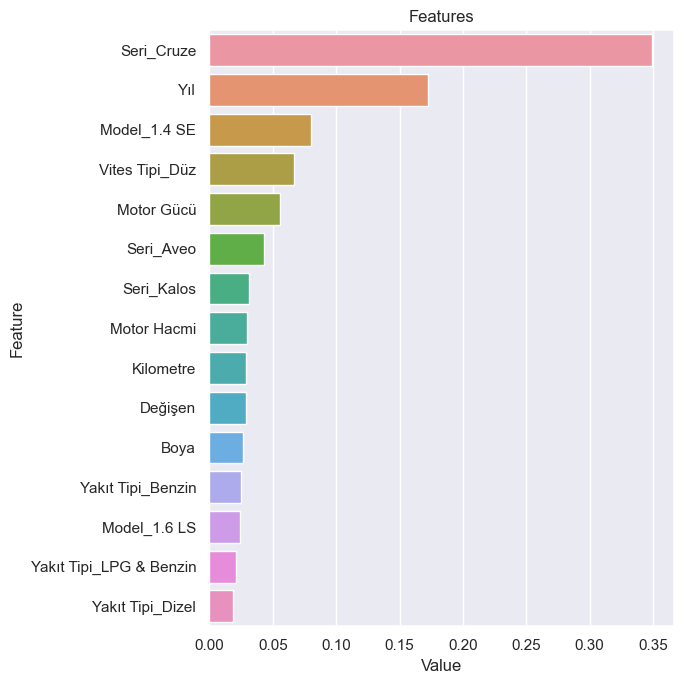

In [18]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)

In [39]:
y_test2 = list(y_test)

In [40]:
df3 = pd.DataFrame(list(zip(y_test, y_pred,(y_pred-y_test))),
               columns =['test', 'pred',"fark"])

In [41]:
df3

,test,pred,fark
0,370000,397806.906250,27806.906250
1,230000,256039.140625,26039.140625
2,320000,288076.000000,-31924.000000
3,278000,244706.218750,-33293.781250
4,455000,403200.468750,-51799.531250
...,...,...,...
259,405000,430625.531250,25625.531250
260,445000,463505.687500,18505.687500
261,335000,355696.406250,20696.406250
262,467500,424067.937500,-43432.062500


In [42]:
df3.describe([0.05,0.25, 0.75,0.90,0.99]).T

,count,mean,std,min,5%,25%,50%,75%,90%,99%,max
test,264.0,345172.678030,98418.231626,154000.000000,214991.500000,269000.000000,351500.000000,405000.000000,450000.000000,507400.000000,975000.0000
pred,264.0,342769.281250,79239.007812,187546.765625,219542.200781,268706.609375,356575.921875,403323.453125,437649.806250,498601.336875,546225.6250
fark,264.0,-2403.424834,58606.417728,-592936.906250,-56305.928125,-21596.687500,2756.820312,22838.773438,46510.065625,81364.408125,83581.8125


In [43]:
df3["test"].max()

975000

In [44]:
df3[df3["test"]==975000]

,test,pred,fark
154,975000,382063.09375,-592936.90625


In [49]:
df3[df3["test"] > 600000]

,test,pred,fark
51,950000,461453.28125,-488546.71875
154,975000,382063.09375,-592936.90625


In [50]:
y_train2 = list(y_train)

In [56]:
for i in y_train2:
    if i > 600000:
        print(i)

610000
849750
650000


In [60]:
df2.describe([0.05,0.25, 0.75,0.90,0.99]).T

,count,mean,std,min,5%,25%,50%,75%,90%,99%,max
Fiyat,874.0,344237.717391,82718.982711,154000.000000,215000.000000,272250.000000,355000.000000,405000.000000,450000.000000,520810.000000,650000.000000
Yıl,874.0,2009.617849,2.749229,2004.000000,2004.000000,2008.000000,2011.000000,2012.000000,2012.000000,2013.000000,2014.000000
Motor Gücü,874.0,0.101894,0.568918,-1.388889,-0.833333,-0.222222,0.194444,0.611111,0.611111,1.694444,1.694444
Motor Hacmi,874.0,-0.418588,0.923252,-3.673077,-1.971154,-0.778846,0.182692,0.182692,0.182692,2.105769,2.105769
Kilometre,874.0,-0.027338,0.474048,-1.161049,-0.679213,-0.365637,-0.074906,0.232210,0.531835,1.305768,2.576779
...,...,...,...,...,...,...,...,...,...,...,...
Model_Z06,874.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Yakıt Tipi_Dizel,874.0,0.102975,0.304100,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
Yakıt Tipi_LPG & Benzin,874.0,0.736842,0.440600,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Vites Tipi_Otomatik,874.0,0.268879,0.443631,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
